<h3>LSTM (Long Short-Term Memory) ile Hisse Senedi Fiyatı Tahminlemesi

1) İş Problemi (Business Problem)
2) Veriyi Anlamak (Data Understanding)
3) Veriyi Hazırlamak (Data Preparation)
4) Modelleme (Modeling)
5) DeğerIendirme (Evaluation)

<h4> 1.) İş Problemi</h4>


- **Date:** İlgili İşlem Gününün tarihini temsil etmektedir.
- **Open:** İlgili işlem gününe ait Hisse başlangıç fiyatını temsil etmektedir.
- **High:** İlgili işlem gününe ait en yüksek fiyatı temsil etmektedir.
- **Low:** İlgili işlem gününe ait en düşük fiyatı temsil etmektedir.
- **Close:** İlgili işlem gününde hisse senedinin kapanış fiyatını temsil etmektedir.
- **Adj Close:** İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatını temsil etmektedir.
- **Volume:** İlgili işlem gününe ait işlem hacmi bilgisini temsil etmektedir.

<h4> 2.) Veriyi Anlamak</h4>


In [6]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras. layers import Dense, LSTM, Dropout
from tensorflow.keras. callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings. filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os. environ ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1. logging.set_verbosity(tf.compat.v1.logging. ERROR)

In [7]:
df = pd.read_csv('TSLA.csv')

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [10]:
df.shape

(2416, 7)

<h4> 3.) Veriyi Hazırlamak</h4>


In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2416 non-null   datetime64[ns]
 1   Open       2416 non-null   float64       
 2   High       2416 non-null   float64       
 3   Low        2416 non-null   float64       
 4   Close      2416 non-null   float64       
 5   Adj Close  2416 non-null   float64       
 6   Volume     2416 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.3 KB


In [14]:
tesla_df = df[['Date','Close']]

In [15]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [16]:
print(tesla_df['Date'].min())
print(tesla_df['Date'].max())

2010-06-29 00:00:00
2020-02-03 00:00:00


In [17]:
tesla_df.index = tesla_df['Date']

In [18]:
tesla_df.drop('Date', axis = 1, inplace = True)

In [19]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [20]:
result_df = tesla_df.copy()

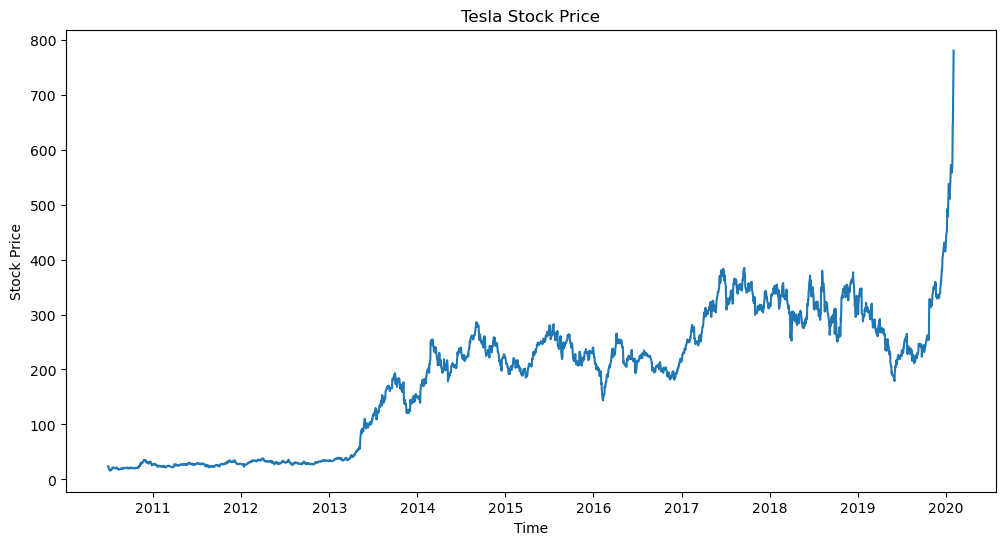

In [21]:
plt.figure(figsize = (12,6))
plt.plot(tesla_df['Close'])
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.title('Tesla Stock Price')
plt.show();

In [22]:
# Verisetinin LSTM ile Modellemek için numpy array'ine çevirmeliyiz.
tesla_df = tesla_df.values

In [23]:
type(tesla_df)

numpy.ndarray

In [24]:
# Verisetinin LSTM ile Modellemek veri tipini float32 olarak tanımlamayıyız.
tesla_df = tesla_df.astype('float32')

Time series verileri söz konusu olduğunda scikit-learn'deki train test split'fonksiyonunu kullanamayız. Zaman örüntüsünün bozulmaması gerekmektedir

In [26]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [27]:
train, test, pos = split_data(tesla_df, 0.2)

In [28]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [29]:
scaler_train = MinMaxScaler(feature_range= (0,1))

In [30]:
train = scaler_train.fit_transform(train)

In [31]:
scaler_test = MinMaxScaler(feature_range= (0,1))

In [32]:
test = scaler_test.fit_transform(test)

In [33]:
train[:3], test[:3]

(array([[0.02191224],
        [0.02174973],
        [0.01668472]], dtype=float32),
 array([[0.25685903],
        [0.24829045],
        [0.25511202]], dtype=float32))

Zaman serilerinde, serinin t anındaki değeri, en fazla kendisinden bir önceki zaman periyodundan etkilenir. <br>
Günlük periyoda sahip bir veri setinde, bir gün öncekine göre yorum yapılır.<br>
Haftalık periyoda sahip bir veri setinde, bir hafta öncekine göre yorum yapılır.<br>
Aylık periyoda sahip bir veri setinde, bir ay öncekine göre yorum yapılır.<br>

Bu yüzden 20 gün önceki değerleri bir feature olarak modele koymaya çalışalım.

In [36]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i,0])

    return np.array(X), np.array(Y)

In [37]:
lookback = 20

In [38]:
# Train veri seti
X_train, y_train = create_features(train, lookback)

In [39]:
# Test veri seti
X_test, y_test = create_features(test, lookback)

In [40]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [41]:
# LSTM, kendisine gelecek verinin 3 boyutlu bir yapıda olmasını ister.
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


<h4> 4.) Modelleme</h4>


In [43]:
# Sıralı katmanlardan oluşan bir sinir ağı oluşturmamızı sağlar.
model = Sequential()

# Units, nöronları ifade eder.
model.add(LSTM(units = 50,
               activation = 'relu',
               input_shape = (X_train.shape[1],lookback)))

# Aşırı öğrenmeyi önlemek için eklenir.
model.add(Dropout(0.2))

# Çıkış katmanı
model.add(Dense(1))
# Çıkış katmanında tek bir tahmin değeri olacağı için 1 nöron olmalıdır.

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

Çıkış değeri sayısal bir değer olduğu için buna uygun loss metrikleri kullanılmalıdır.

In [47]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min")]

In [48]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

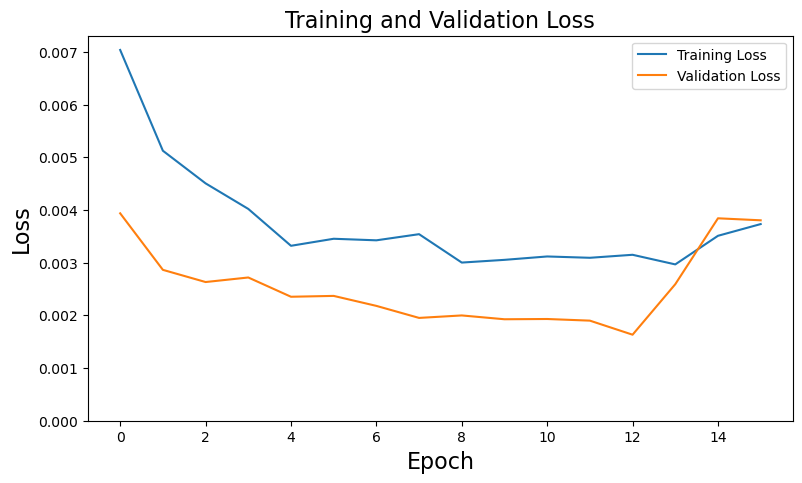

In [49]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()


<h4> 5.) Değerlendirme</h4>


In [50]:
loss = model.evaluate(X_test, y_test, batch_size = 1)
print("\nTest Loss : %.1f%%" % (100.0 * loss))

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041

Test Loss : 0.4%


In [51]:
train_predict = model.predict(X_train)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [52]:
test_predict = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [53]:
# Scale işlemini geri alarak değerleri kontrol edelim.
train_predict = scaler_train.inverse_transform(train_predict) 
test_predict = scaler_test.inverse_transform(test_predict) 

In [54]:
y_train = scaler_train.inverse_transform(y_train) 
y_test = scaler_test.inverse_transform(y_test) 

In [55]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [56]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [57]:
print(f"Eğitim RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Eğitim RMSE: 16.645660400390625
Test RMSE: 37.065670013427734


Tahmin yapmak istediğimizde, 37 birimlik bir sapma payı vardır.

In [66]:
train_prediction_df = result_df[lookback:pos]

Lookback = 20 olduğu için ilk 20 verinin tahminini yapamayız. lookback yani 20'den başlayarak veri setini oluştururuz.

In [68]:
train_prediction_df.head()

,Close
Date,
2010-07-28,20.719999
2010-07-29,20.350000
2010-07-30,19.940001
2010-08-02,20.920000
2010-08-03,21.950001


In [70]:
train_prediction_df['Predicted'] = train_predict

In [72]:
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,37.596512
2010-07-29,20.350000,37.559212
2010-07-30,19.940001,37.532696
2010-08-02,20.920000,37.530514
2010-08-03,21.950001,37.530514


In [76]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,325.301392
2018-04-04,286.940002,322.991821
2018-04-05,305.720001,322.922607
2018-04-06,299.299988,327.401642
2018-04-09,289.660004,327.408722


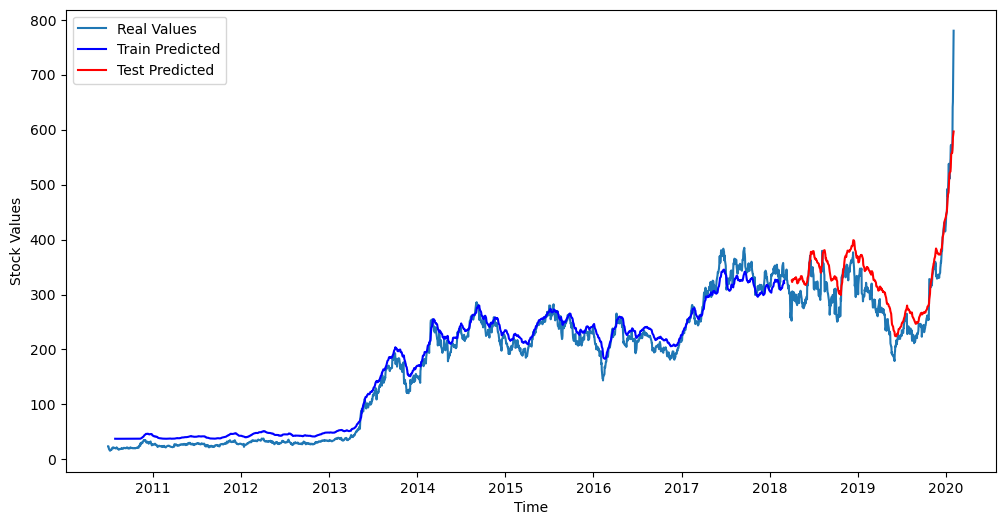

In [85]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(12,6))
plt.plot(result_df, label = 'Real Values')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = 'Train Predicted')
plt.plot(test_prediction_df["Predicted"], color = 'red', label = 'Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()